# Federated Learning Contribution Measure Model (Income dataset)
This notebook implements a simple contribution model based on the notebook exemple of the DeAI repository. More precisely, it emulates a framework where `NUM_CLIENTS` clients are learning adult income prediction and average their models.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

import time

# Custom functions
from helpers import *

# Visualization
from matplotlib import pyplot as plt
from visualization import *
plt.rc('legend', fontsize='small')
plt.style.use('bmh')

# Reproductibiity
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)

# Console priniting option
np.set_printoptions(precision=3, suppress=False)

### Model 
`FC_Net` is strongly inspired by the model found in https://www.kaggle.com/chriszou/titanic-with-pytorch-nn-solution

In [2]:
from models import FC_Net

### Federated Learning Contribution Measure
The following cells implement the case where the central server intitialize the model and the contributions of each user (to zero).

Then, for $t=1,...,r$ with $r=$ `NUM_ROUNDS`:
1. The central server evaluates the performance of the model on a test datasets (theoretically representing the distribution across users, i.e. the overall tasks),
2. The central server distributes the model to **all** the `NUM_CLIENTS` clients,
3. Each client trains the model on its own data (`EPOCHS` times using batch of size `BATCH_SIZE`),
4. Each client sends the trained model to the central server,
5. The central server aggregates the models and update the contributions of each user.

### Data loading and analysis

Mean of each feature:
age                    38.643585
workclass               3.870439
fnlwgt             189664.134597
education              10.288420
educational-num        10.078089
marital-status          2.618750
occupation              6.577700
relationship            1.443287
race                    3.668052
gender                  0.668482
capital-gain         1079.067626
capital-loss           87.502314
hours-per-week         40.422382
native-country         36.749355
income                  0.239282
dtype: float64

Number of features (with embeddings): 59


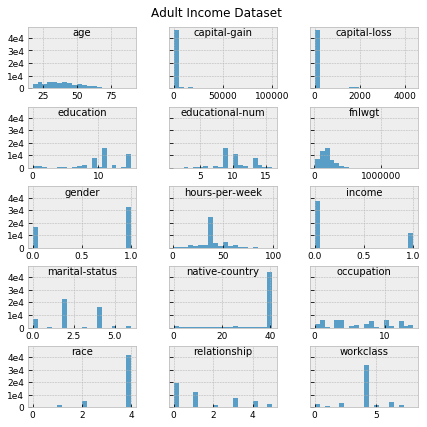

In [14]:
# loading
all_df, meta = load_into_df('income')

# plotting histograms
fig_all = all_df.hist(alpha=0.8, bins=20, figsize=(7, 7), 
                      layout=(5,3), sharey=True, xlabelsize=9, ylabelsize=9)


# style
plt.suptitle('Adult Income Dataset', y=0.92)
for x in fig_all.ravel():
    x.title.set_position([0.5, 0.76, 0, 0])
    x.title.set_size(10)
    x.title.set_size(10)
    x.set_yticks([0, 10000, 20000, 30000, 40000])
    x.set_yticklabels(['0', '1e4', '2e4', '3e4', '4e4'])

# saving
plt.savefig('./figures/adult_hist.png')

# statistics
print('Mean of each feature:\n{}\n'.format(all_df.mean()))
print('Number of features (with embeddings): {}'.format(meta['n_feat']))

### Parameters (to be specified)

In [15]:
# Dataset splitting
NUM_CLIENTS = 4
SIZES = [0.25, 0.25, 0.25, 0.25]
Y_ACC = [1., 0.98, 0.96, 0.94]
X_NOISE = None
X_ACC = None

# Training parameters
NUM_ROUNDS = 1
EPOCHS = 1
LR = 1e-3
BATCH_SIZE = 32
F_TOT = 1
F_TEST = 0.3
THRESHOLD = 0.5
CRITERION = nn.BCELoss()
METRIC = 'loss_norm'
PROFIT = not METRIC == 'loss_norm'
VERBOSE = True

# Model architecture
LIN_LAYERS_SIZES = [64, 16, 4]
OUTPUT_SIZE = 1

# Normalizing the datasets
all_df_norm = normalize(all_df, meta)

# Splitting the data into several datasets (train + test)
train_ds, test_ds = df_to_ds(all_df_norm, SIZES, meta, f_test=F_TEST, x_noise=X_NOISE, x_acc=X_ACC, y_acc=Y_ACC)

# Creating the dataloaders
train_loaders = ds_to_dataloaders(train_ds, BATCH_SIZE)
test_loaders = ds_to_dataloaders(test_ds, 10*BATCH_SIZE)
test_loader_s = ds_to_dataloaders(torch.utils.data.ConcatDataset(test_ds), 10*BATCH_SIZE)
marg_test_loaders = [ds_to_dataloaders(torch.utils.data.ConcatDataset(test_ds[:i] + test_ds[i:]), 10*BATCH_SIZE) for i in range(NUM_CLIENTS)]

Sizes:
Full dataset: 48842
Splitted datasets (total): 48840 (train: 34188, test: 14652)
Per client: [12210, 12210, 12210, 12210]


### Marginal loss with Shapley values

In [5]:
# initial model
initial_model = FC_Net(meta["emb_dims"], meta["n_cont"], LIN_LAYERS_SIZES, OUTPUT_SIZE)

# coalition models
coal_models = {}
coal_models_agg = {} 
coal_models_clients = {}

for coal in powerset(range(NUM_CLIENTS)):
    coal_models[coal] = FC_Net(meta["emb_dims"], meta["n_cont"], LIN_LAYERS_SIZES, OUTPUT_SIZE)
    coal_models[coal].load_state_dict(initial_model.state_dict())

    coal_models_agg[coal] = FC_Net(meta["emb_dims"], meta["n_cont"], LIN_LAYERS_SIZES, OUTPUT_SIZE)
    
    
    if coal != ():
        coal_models_clients[coal] = [FC_Net(meta["emb_dims"], meta["n_cont"], LIN_LAYERS_SIZES, OUTPUT_SIZE) for _ in coal]
    else:
        coal_models_clients[coal] = [FC_Net(meta["emb_dims"], meta["n_cont"], LIN_LAYERS_SIZES, OUTPUT_SIZE)]
        coal_models_agg[coal].load_state_dict(initial_model.state_dict())
        
# keys for the global model and the leave-one-out marginal models
global_coal = tuple(range(NUM_CLIENTS))
marg_coals = [tuple([i for i in range(NUM_CLIENTS) if i != j]) for j in range(NUM_CLIENTS)]

# performance measures
perf = initialize_perf((NUM_ROUNDS+1, 1)) # perf[0] contains the performance prior to learning
marg_perf = initialize_perf((NUM_ROUNDS, NUM_CLIENTS))
marg_perf_agg = initialize_perf((NUM_ROUNDS, NUM_CLIENTS))
perf_marg_ds = initialize_perf((NUM_ROUNDS, NUM_CLIENTS))
  
# contribution
SV = np.zeros((NUM_ROUNDS, NUM_CLIENTS))
SVa = np.zeros((NUM_ROUNDS, NUM_CLIENTS))
ML = np.zeros((NUM_ROUNDS, NUM_CLIENTS))
MLa = np.zeros((NUM_ROUNDS, NUM_CLIENTS))

# Untrained performance
fill_perf_history(evaluate_model(initial_model, test_loader_s, CRITERION, THRESHOLD), perf, (0, 0))
print('Prior performance ({}): {:.3f}'.format(METRIC, perf[METRIC][0, 0]))

# Iteration
for r in range(NUM_ROUNDS):
    t_start = time.time()
    if VERBOSE:
        print("------------------------------------\nRound {}:".format(r+1), end='')
    else:
        print("Round {}/{} (current {}: {:.3f})".format(r+1, NUM_ROUNDS, METRIC, perf[METRIC][r, 0]), end='\r')
        
    for coal in powerset(range(NUM_CLIENTS)):
        loss = 0
        for i, model in zip(coal, coal_models_clients[coal]):
            
            # step 1: Sending the models (emulating)
            model.load_state_dict(coal_models[coal].state_dict())
            
            # step 2: local training
            opt = optim.SGD(model.parameters(), lr=LR)
            loss += client_update(model, opt, CRITERION, train_loaders[i], epoch=EPOCHS)
      
    # step 4: aggregation
    for coal in powerset(range(NUM_CLIENTS)): 
        average_models(coal_models[coal], coal_models_clients[coal])
        if coal != ():
            average_models(coal_models_agg[coal], [coal_models_clients[global_coal][i] for i in coal])
    
    # global model performance on total test datasets
    fill_perf_history(evaluate_model(coal_models[global_coal], test_loader_s, CRITERION, THRESHOLD), perf,  (r + 1, 0))
    
    # step 5. Updating the contributions
    if NUM_CLIENTS >1:
        
        # SV and SVa
        SV[r, :] = ShapleyValues(NUM_CLIENTS, coal_models, marg_test_loaders, METRIC, CRITERION, THRESHOLD)
        SVa[r, :] = ShapleyValues(NUM_CLIENTS, coal_models_agg, marg_test_loaders, METRIC, CRITERION, THRESHOLD)
        
        # ML and MLa
        for i in range(NUM_CLIENTS):
            # global model performance on marginal test datasets
            fill_perf_history(evaluate_model(coal_models[global_coal], marg_test_loaders[i], CRITERION, THRESHOLD), perf_marg_ds, (r, i))
            # marginal models performance on marginal test datasets
            fill_perf_history(evaluate_model(coal_models[marg_coals[i]], marg_test_loaders[i], CRITERION, THRESHOLD), marg_perf, (r, i))
            # marginal models (during aggregation) performance on marginal test datasets
            fill_perf_history(evaluate_model(coal_models_agg[marg_coals[i]], marg_test_loaders[i], CRITERION, THRESHOLD), marg_perf_agg, (r, i))
        
        ML[r, :]= marginal_contribution(perf_marg_ds[METRIC][r, :], marg_perf[METRIC][r, :], profit=PROFIT)
        MLa[r, :] = marginal_contribution(perf_marg_ds[METRIC][r, :], marg_perf_agg[METRIC][r, :], profit=PROFIT)
        
        t_round = time.time() - t_start
        if VERBOSE:
            print(" ({:.1f}s)".format(t_round))
            print("Performance:  {:.3f} ".format(perf[METRIC][r+1, 0]))
            print("SV:")
            print("  Total:      {}".format(SV[r, :]))
            print("  Cumulative: {}".format(SV.sum(0)))
            print("SVa:")
            print("  Total:      {}".format(SVa[r, :]))
            print("  Cumulative: {}".format(SVa.sum(0)))
            print("ML:")
            print("  Total:      {}".format(ML[r, :]))
            print("  Cumulative: {}".format(ML.sum(0)))
            print("MLa:")
            print("  Total:      {}".format(MLa[r, :]))
            print("  Cumulative: {}".format(MLa.sum(0)))
            
fill_perf_history(evaluate_model(coal_models[global_coal], test_loader_s, CRITERION, THRESHOLD), perf,  (-1, 0))
print("------------------------------------\nFinal performance ({}): {:.3f}".format(METRIC, perf[METRIC][-1, 0]))

Prior performance (loss_norm): 0.002
------------------------------------
Round 1: (11.6s)
Performance:  0.002 
SV:
  Total:      [0. 0. 0. 0.]
  Cumulative: [0. 0. 0. 0.]
SVa:
  Total:      [-1.658e-06 -2.882e-07 -2.721e-06  2.305e-06]
  Cumulative: [-1.658e-06 -2.882e-07 -2.721e-06  2.305e-06]
ML:
  Total:      [-4.947e-06  1.073e-06 -7.315e-06 -1.017e-05]
  Cumulative: [-4.947e-06  1.073e-06 -7.315e-06 -1.017e-05]
MLa:
  Total:      [ 4.696e-06 -1.947e-06 -1.513e-05  9.351e-06]
  Cumulative: [ 4.696e-06 -1.947e-06 -1.513e-05  9.351e-06]
------------------------------------
Final performance (loss_norm): 0.002


### Training history vizualization

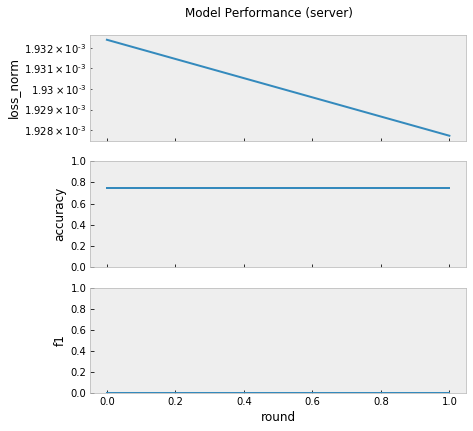

In [7]:
plotmetrics = ['loss_norm', 'accuracy', 'f1']
legends = SIZES
#legends = ['40% - y_acc: 95%', '30% - y_acc: 95%', '20% - y_acc: 95%', '40% - y_acc: 100%']

# Model performance
fig_perf = perfplots(perf, suptitle='Model Performance (server)', metrics=plotmetrics)


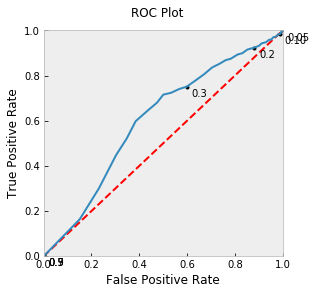

In [8]:
# ROC curve
fig_ROC = ROC(coal_models[global_coal], test_loader_s)

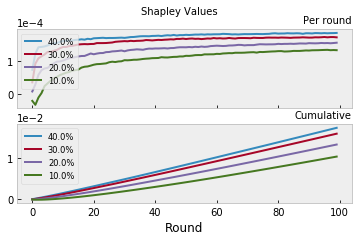

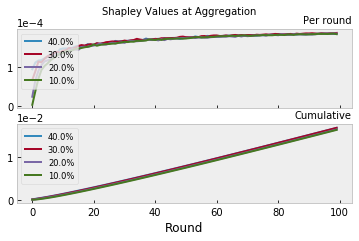

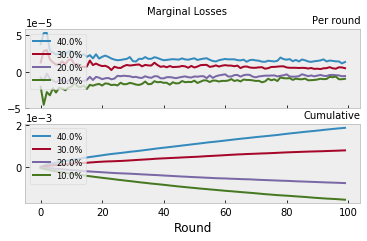

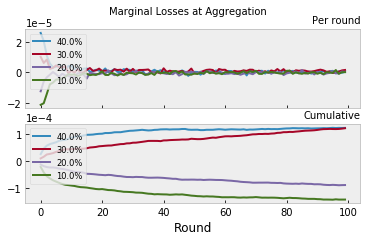

In [17]:
# Contribution plot
modes = ['round_maxmax', 'round_minmax', 'cum', 'minmax', 'maxmax']
modes = ['round', 'cum']
fig_SV = contriplot(SV, legends=legends, normalize=True, modes=modes, suptitle="Shapley Values")
fig_SVa = contriplot(SVa, legends=legends, normalize=True, modes=modes, suptitle="Shapley Values at Aggregation")
fig_ML = contriplot(ML, legends=legends, normalize=True, modes=modes, suptitle="Marginal Losses")
fig_MLa = contriplot(MLa, legends=legends, normalize=True, modes=modes, suptitle="Marginal Losses at Aggregation")

### Saving

In [10]:
from datetime import datetime
import dill
import os

### Saving the relevant objects
now = datetime.now()
time = now.strftime('%d_%m_%Hh%M')
subdir = "FL_n{}_r{}_{}/".format(NUM_CLIENTS, NUM_ROUNDS, time)

fig_dir = './saves/' + subdir + 'figures/'
save_dir = './saves/' + subdir

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
print(save_dir)

./saves/FL_n4_r100_26_05_03h29/


Figures

In [11]:
fig_perf.savefig(fig_dir + 'perf.png')
fig_ROC.savefig(fig_dir + 'ROC.png')
fig_SV.savefig(fig_dir + 'SV.png')
fig_SVa.savefig(fig_dir + 'SVa.png')
fig_ML.savefig(fig_dir + 'ML.png')
fig_MLa.savefig(fig_dir + 'MLa.png')

Variables

In [12]:
dill.dump_session(save_dir + 'variables.pckl')

### Loading

In [16]:
import dill
directory = './saves/FL_n4_r100_25_05_23h42/'
dill.load_session(directory + 'variables.pckl')